In [28]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [29]:
reddit_df = pd.read_csv('year_reddit_data.csv')
yf_df = pd.read_csv('year_yf_data.csv')

print(reddit_df.head())
print(yf_df.head())


   Unnamed: 0       id          created_utc ticker subreddit  \
0           0  1p1ked6  2025-11-19 21:26:49   nvda    stocks   
1           1  1p1kd0p  2025-11-19 21:25:24   nvda    stocks   
2           2  1p1iecs  2025-11-19 20:11:40   nvda    stocks   
3           3  1p1ey7l  2025-11-19 18:06:26   nvda    stocks   
4           4  1p0kfm6  2025-11-18 18:53:45   nvda    stocks   

               author                                              title  \
0         Not69Batman    NVDA Quarterly Revenue $57 billion (up 62% YoY)   
1           Puginator  Nvidia shares rise on stronger than expected r...   
2  West-Sprinkles8210            No one really cares about NVDA earnings   
3         dodgydave44  Question about single stock leveraged ETFs and...   
4         Not69Batman  MSFT and NVDA to invest in Anthropic as Claude...   

                                            selftext  score  upvote_ratio  \
0  NVDA Quarterly Results:\n\nRevenue = $57.006 b...    259          0.97   
1  N

# Reddit + Yahoo Finance preprocessing pipeline

This notebook prepares weekly sequences for the BiLSTM self-attention model.

Steps:
- Normalize schemas and dates on `reddit_df` and `yf_df`.
- Clean text (remove URLs, whitespace) and detect ticker mentions.
- Compute FinBERT embeddings and sentiment per post.
- Aggregate per ticker-day: engagement-weighted embedding and sentiment/engagement features.
- Join OHLCV from Yahoo Finance data.
- Build 5-day windows and next-week labels (direction/magnitude).
- Create a WeeklySentimentDataset and collate a batch.
- Run the batch through `LSTMClassifier` to verify shapes.

In [30]:
import re
from datetime import datetime, timedelta

from transformers import AutoTokenizer, AutoModelForSequenceClassification


def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"\n+", " ", text)
    return re.sub(r"\s+", " ", text).strip()


def load_finbert(device):
    tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    mdl = AutoModelForSequenceClassification.from_pretrained(
        "ProsusAI/finbert", output_hidden_states=True
    ).to(device)
    mdl.eval()
    return tok, mdl


@torch.no_grad()
def finbert_embed_and_sentiment(texts, tokenizer, model, device, batch_size: int = 16):
    all_embeds = []
    all_scores = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i : i + batch_size]
        enc = tokenizer(chunk, padding=True, truncation=True, max_length=128, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        hidden = out.hidden_states[-1]
        mask = enc["attention_mask"].unsqueeze(-1)
        masked = hidden * mask
        lengths = mask.sum(dim=1).clamp_min(1)
        mean_pool = masked.sum(dim=1) / lengths
        logits = out.logits
        probs = torch.softmax(logits, dim=-1)
        score = probs[:, 2] - probs[:, 0]
        all_embeds.append(mean_pool.cpu())
        all_scores.append(score.cpu())
    return torch.cat(all_embeds, dim=0), torch.cat(all_scores, dim=0)

In [31]:
# Normalize schemas
reddit = reddit_df.copy()
yf = yf_df.copy()

# Reddit expected columns: ['post.id','post.created_utc','post.title','post.selftext','post.ups','post.downs','post.upvote_ratio','post.num_comments','post.score','Post.subreddit.display_name','Ticker_id']
# Map to simpler names if present
col_map = {
    'post.id': 'post_id',
    'post.created_utc': 'created_utc',
    'post.title': 'title',
    'post.selftext': 'selftext',
    'post.ups': 'ups',
    'post.downs': 'downs',
    'post.upvote_ratio': 'upvote_ratio',
    'post.num_comments': 'num_comments',
    'post.score': 'score',
    'Post.subreddit.display_name': 'subreddit',
    'Ticker_id': 'ticker'
}
reddit.rename(columns={k: v for k, v in col_map.items() if k in reddit.columns}, inplace=True)

# Parse datetime and clean text
if 'created_utc' in reddit.columns:
    reddit['created_utc'] = pd.to_datetime(reddit['created_utc'], utc=True, errors='coerce')
else:
    raise ValueError('created_utc column not found in reddit_df')

# Ensure ticker exists and normalize to uppercase so it matches YF tickers
if 'ticker' not in reddit:
    if 'Ticker_id' in reddit_df.columns:
        reddit['ticker'] = reddit_df['Ticker_id'].astype(str)
    else:
        raise ValueError('ticker/Ticker_id column required in reddit_df')
reddit['ticker'] = reddit['ticker'].astype(str).str.upper()

# Prepare title + selftext; include selftext embeddings (concatenate cleaned title and cleaned selftext)
reddit['title'] = reddit.get('title', '').astype(str)
reddit['selftext'] = reddit.get('selftext', '').astype(str).fillna('')
reddit['title_clean'] = reddit['title'].map(clean_text)
reddit['selftext_clean'] = reddit['selftext'].map(clean_text)
reddit['text'] = (reddit['title_clean'] + ' ' + reddit['selftext_clean']).str.strip()

# Ensure numeric engagement columns exist
for c, dtp, default in [
    ('ups', int, 0), ('downs', int, 0), ('num_comments', int, 0),
    ('score', int, 0), ('upvote_ratio', float, 0.0)
]:
    if c not in reddit:
        reddit[c] = default
    reddit[c] = reddit[c].fillna(default).astype(dtp)

# Yahoo Finance CSV has multi-level headers (field, ticker). Re-parse and pivot to long format.
# Example fields: Close, High, Low, Open, Volume
yf_path = 'year_yf_data.csv'
try:
    yf_multi = pd.read_csv(yf_path, header=[0, 1], index_col=0, skiprows=[2])
except Exception as e:
    raise RuntimeError(f'Failed to parse {yf_path} with multi-level headers: {e}')

# Ensure index is datetime-like (dates in the first column)
yf_multi.index.name = 'date'
try:
    yf_multi.index = pd.to_datetime(yf_multi.index, errors='coerce')
except Exception:
    pass

# Helper to convert a category to long format
def _to_long(cat: str) -> pd.DataFrame:
    if cat not in yf_multi.columns.get_level_values(0):
        return pd.DataFrame(columns=['date', 'ticker', cat])
    dfc = yf_multi[cat]
    long_df = dfc.stack().reset_index()
    long_df.columns = ['date', 'ticker', cat]
    return long_df

close_long = _to_long('Close')
vol_long = _to_long('Volume')

# Merge desired fields
if close_long.empty and vol_long.empty:
    yf = pd.DataFrame(columns=['date', 'ticker', 'Close', 'Volume'])
else:
    yf = close_long.merge(vol_long, on=['date', 'ticker'], how='outer')

# Finalize types and normalize ticker case
yf['date'] = pd.to_datetime(yf['date'], errors='coerce').dt.date
yf['ticker'] = yf['ticker'].astype(str).str.upper()

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# FinBERT embeddings + sentiment per post (title+selftext)
print('Embedding posts (FinBERT) for combined title+selftext...')
fin_tok, fin_model = load_finbert(device)
embeds, sent = finbert_embed_and_sentiment(reddit['text'].tolist(), fin_tok, fin_model, device)
reddit['embed'] = [e.cpu().numpy() if isinstance(e, torch.Tensor) else e for e in embeds]
reddit['sentiment'] = sent.cpu().numpy()

# Separate sentiment for selftext only
print('Embedding selftext alone for separate sentiment score...')
_self_embeds, self_sent = finbert_embed_and_sentiment(reddit['selftext_clean'].tolist(), fin_tok, fin_model, device)
reddit['selftext_sentiment'] = self_sent.cpu().numpy()

# Daily aggregation per ticker-date using available columns: score, upvote_ratio, num_comments
reddit['date'] = reddit['created_utc'].dt.tz_convert('US/Eastern').dt.date
agg_rows = []
for (tic, dt), g in reddit.groupby(['ticker','date'], sort=True):
    arr = np.stack(g['embed'].values, axis=0)
    scores = g['score'].astype(float).to_numpy()
    pos_scores = np.clip(scores, a_min=0.0, a_max=None)
    if pos_scores.sum() <= 0:
        w = np.full_like(pos_scores, 1.0 / len(pos_scores))
    else:
        w = pos_scores / pos_scores.sum()
    day_embed = (arr * w[:, None]).sum(axis=0).astype(np.float32)
    sentiment_mean = float(g['sentiment'].mean())
    sentiment_weighted = float((g['sentiment'] * w).sum())
    selftext_sentiment_mean = float(g['selftext_sentiment'].mean())
    selftext_sentiment_weighted = float((g['selftext_sentiment'] * w).sum())
    score_sum = float(scores.sum())
    score_mean = float(scores.mean())
    upvote_ratio_mean = float(g['upvote_ratio'].mean()) if 'upvote_ratio' in g else 0.0
    num_comments = g['num_comments'].astype(float).to_numpy() if 'num_comments' in g else np.zeros_like(scores)
    num_comments_sum = float(num_comments.sum())
    num_comments_mean = float(num_comments.mean()) if len(num_comments) else 0.0
    denom = np.maximum(pos_scores, 1.0)
    comment_engagement_mean = float((num_comments / denom).mean())
    row = {
        'ticker': tic,
        'date': dt,
        'embed': day_embed,
        'sentiment_mean': sentiment_mean,
        'sentiment_weighted': sentiment_weighted,
        'selftext_sentiment_mean': selftext_sentiment_mean,
        'selftext_sentiment_weighted': selftext_sentiment_weighted,
        'score_sum': score_sum,
        'score_mean': score_mean,
        'upvote_ratio_mean': upvote_ratio_mean,
        'num_comments_sum': num_comments_sum,
        'num_comments_mean': num_comments_mean,
        'comment_engagement_mean': comment_engagement_mean,
    }
    agg_rows.append(row)
agg = pd.DataFrame(agg_rows)

# Merge OHLCV
merged = agg.merge(yf.rename(columns={'Ticker':'ticker'}), how='left', on=['ticker','date'])

# Build sequences and labels (next-week direction/magnitude)
seq_len = 5
sequences = []
lengths = []
labels_dir = []
labels_mag = []
meta = []

for tic, g in merged.sort_values('date').groupby('ticker'):
    g = g.reset_index(drop=True)
    def feat_vec(r):
        return np.concatenate([
            r['embed'],
            np.array([
                r.get('Close', np.nan),
                r.get('Volume', np.nan),
                r.get('sentiment_mean', 0.0),
                r.get('sentiment_weighted', 0.0),
                r.get('selftext_sentiment_mean', 0.0),
                r.get('selftext_sentiment_weighted', 0.0),
                r.get('score_sum', 0.0),
                r.get('score_mean', 0.0),
                r.get('upvote_ratio_mean', 0.0),
                r.get('num_comments_sum', 0.0),
                r.get('num_comments_mean', 0.0),
                r.get('comment_engagement_mean', 0.0),
            ], dtype=np.float32)
        ]).astype(np.float32)
    feats = [feat_vec(r) for _, r in g.iterrows()]
    closes = g['Close'].to_numpy()
    if len(feats) < seq_len + 5:
        continue
    for i in range(0, len(feats) - seq_len - 5 + 1):
        window = np.stack(feats[i:i+seq_len], axis=0)
        c0 = closes[i+seq_len-1]
        c1 = closes[i+seq_len+2-1]
        if np.isnan(c0) or np.isnan(c1):
            continue
        ret = (c1 - c0) / max(abs(c0), 1e-6)
        direction = 1.0 if ret > 0 else 0.0
        magnitude = float(abs(ret))
        sequences.append(torch.tensor(window, dtype=torch.float32))
        lengths.append(seq_len)
        labels_dir.append(direction)
        labels_mag.append(magnitude)
        meta.append({'ticker': tic, 'start_index': i})

print(f'Built {len(sequences)} sequences across {merged["ticker"].nunique()} tickers')

Embedding posts (FinBERT) for combined title+selftext...
Embedding selftext alone for separate sentiment score...
Embedding selftext alone for separate sentiment score...
Built 1338 sequences across 12 tickers
Built 1338 sequences across 12 tickers


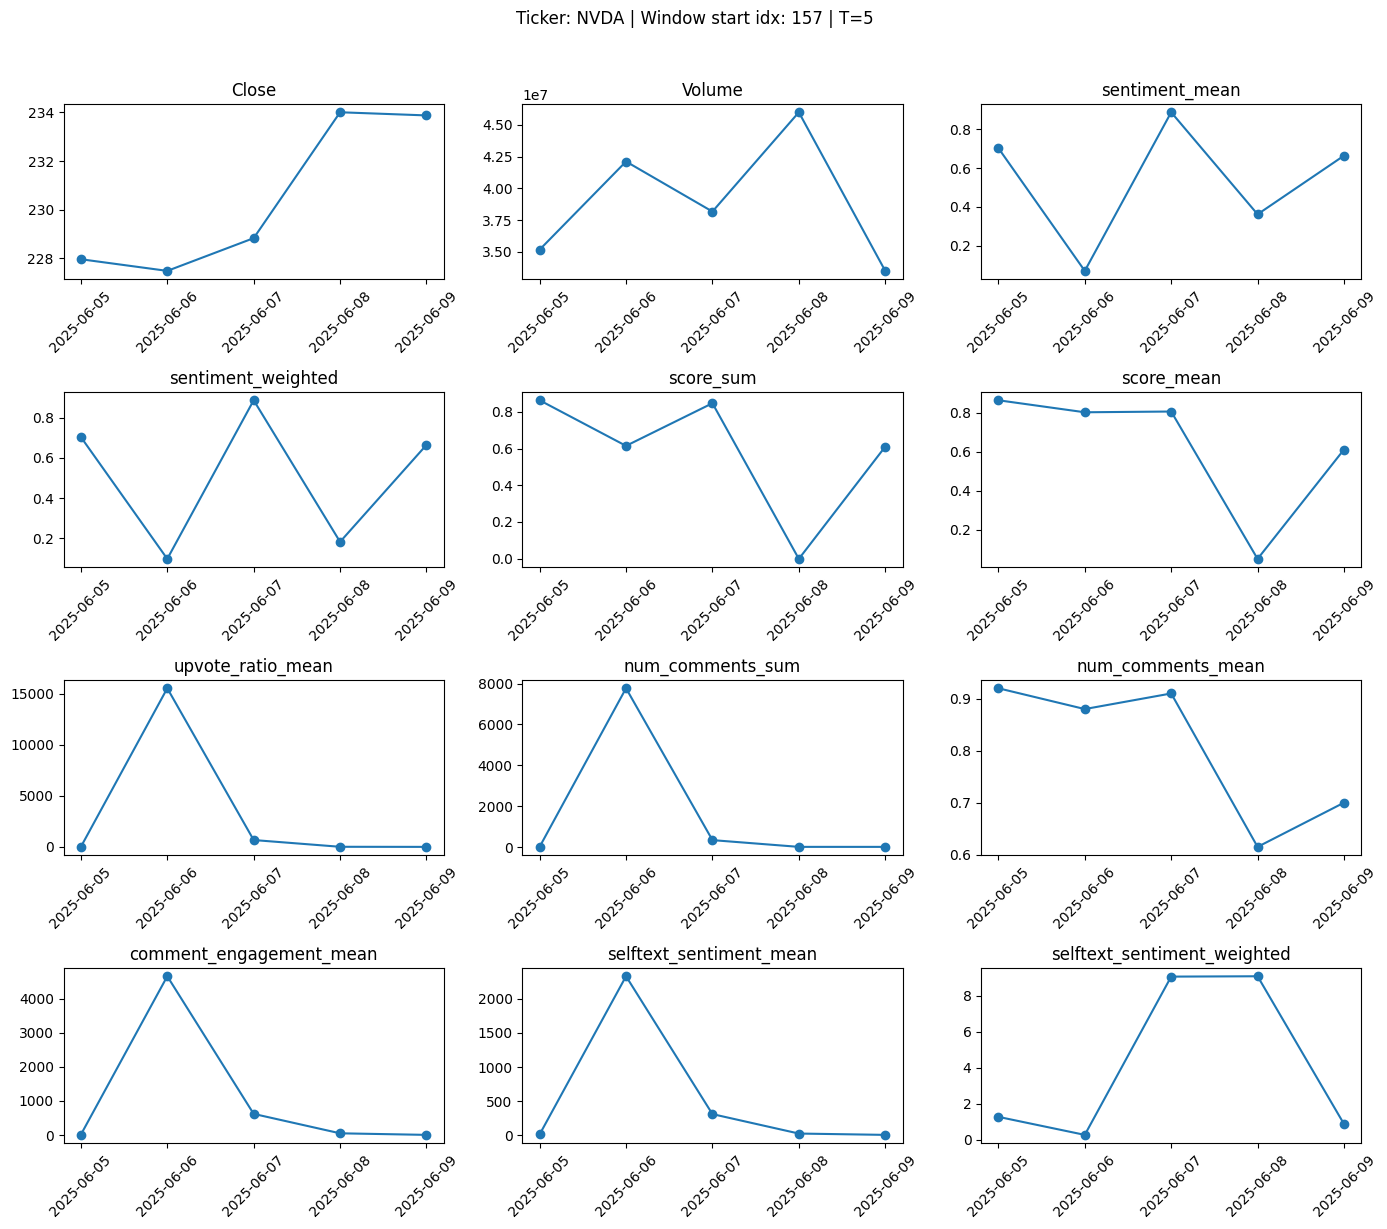

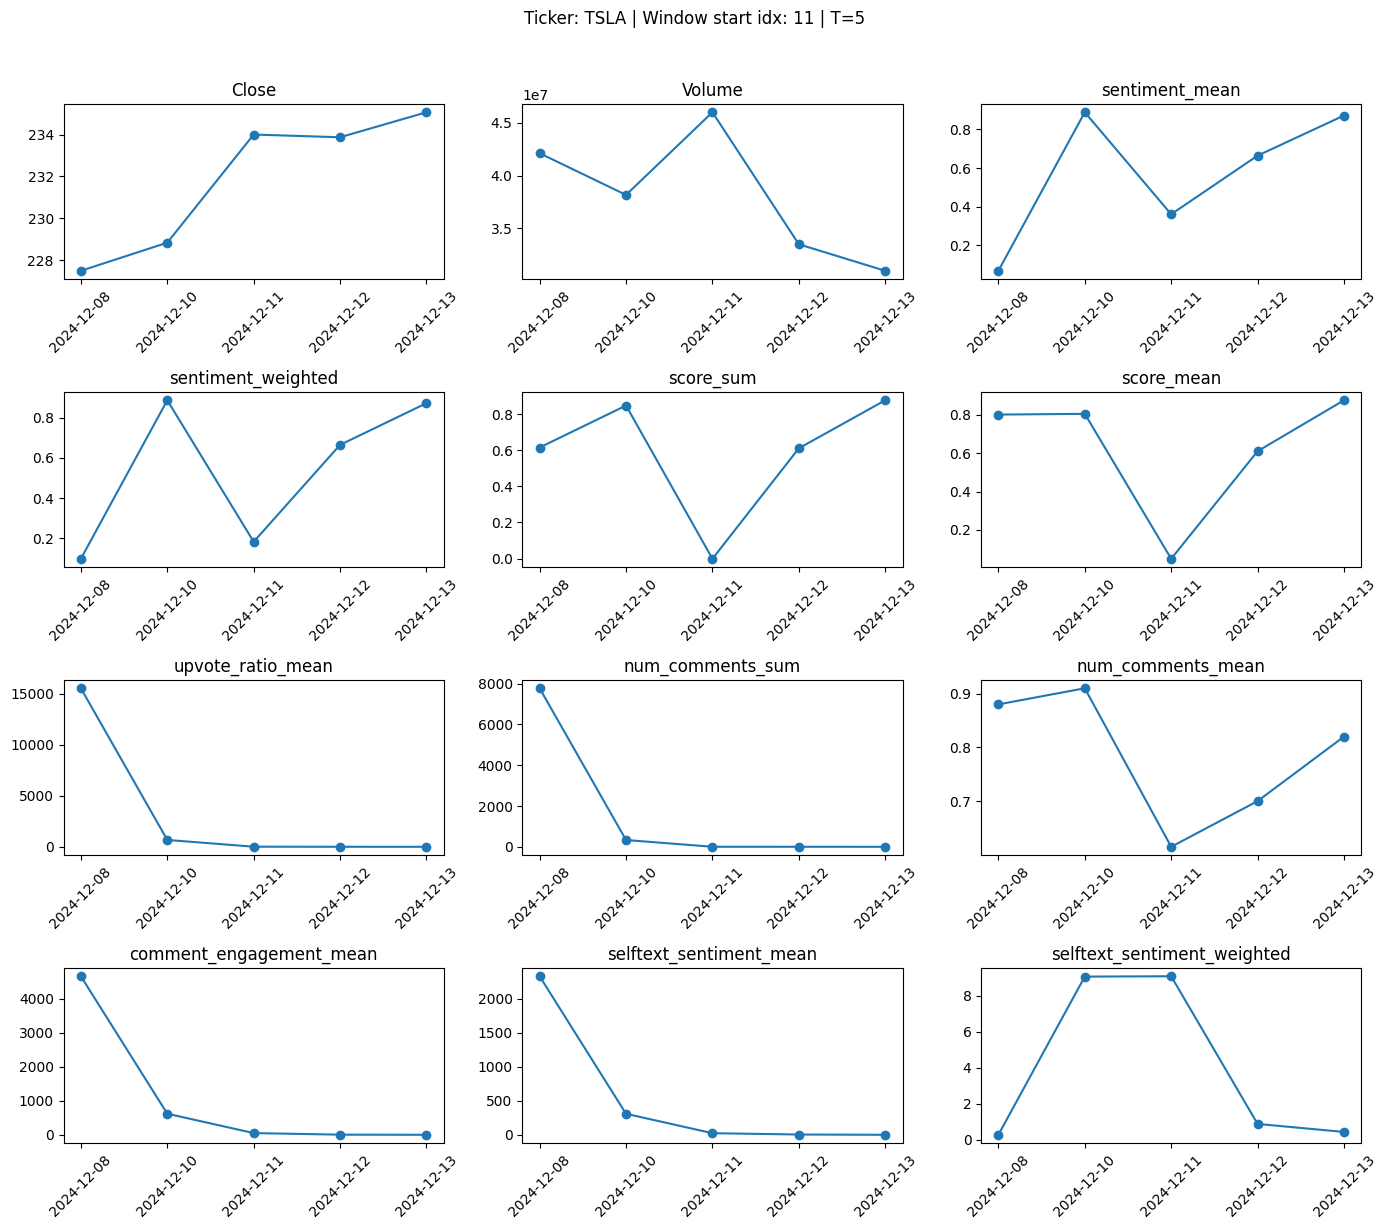

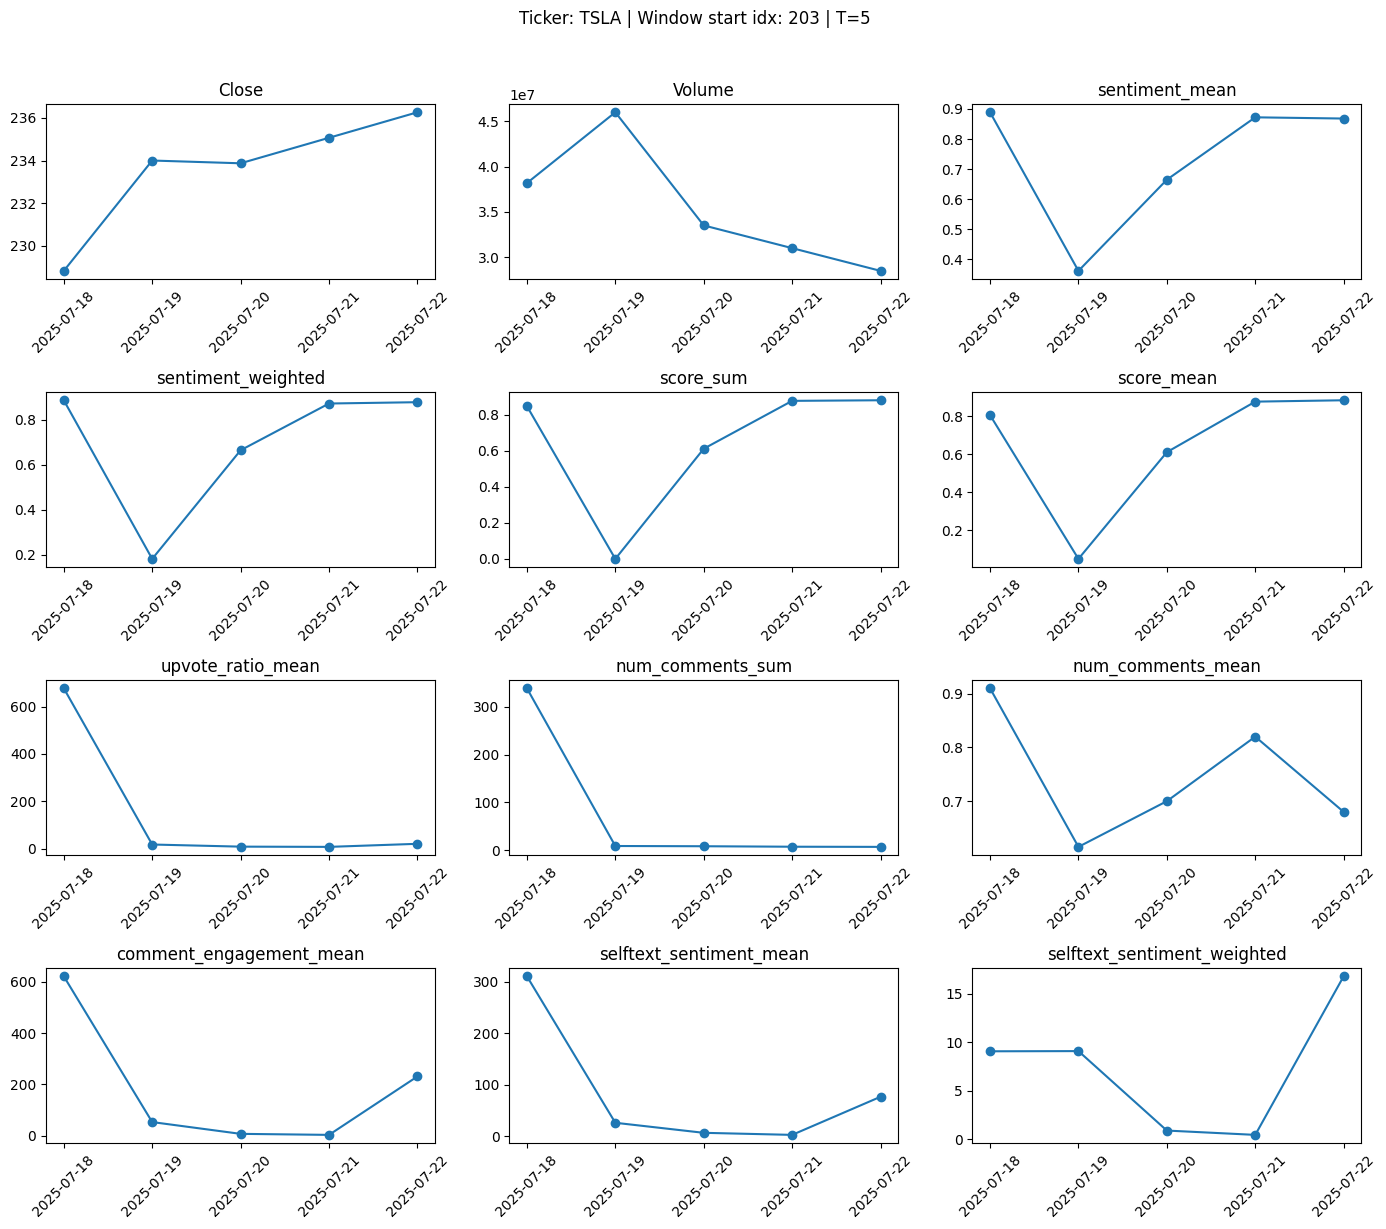

In [41]:
# Visualize a few sample sequences (numeric features over the window)
if len(globals().get('sequences', [])) == 0:
    print('No sequences to visualize. Run the previous cell to build sequences first.')
else:
    feature_names = [
        'Close', 'Volume', 'sentiment_mean', 'sentiment_weighted',
        'score_sum', 'score_mean', 'upvote_ratio_mean', 'num_comments_sum', 'num_comments_mean', 'comment_engagement_mean', 'selftext_sentiment_mean', 'selftext_sentiment_weighted'
    ]
    num_feats = len(feature_names)
    D = int(sequences[0].shape[1])
    embed_dim = D - num_feats

    n_show = min(3, len(sequences))
    for k in range(n_show):
        seq = sequences[k].cpu().numpy()
        meta_k = meta[k] if k < len(meta) else {}
        tic = meta_k.get('ticker', 'NA')
        start_idx = int(meta_k.get('start_index', 0))
        T = seq.shape[0]
        numeric = seq[:, embed_dim:]

        dates = list(range(T))
        try:
            g = (merged[merged['ticker'] == tic]
                 .sort_values('date')
                 .reset_index(drop=True))
            dates = g.loc[start_idx:start_idx+T-1, 'date'].astype(str).tolist()
        except Exception:
            pass

        cols = 3
        rows = int(math.ceil(num_feats / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(14, 3*rows))
        axes = axes.flatten()
        for i, fname in enumerate(feature_names):
            ax = axes[i]
            ax.plot(dates, numeric[:, i], marker='o')
            ax.set_title(fname)
            ax.tick_params(axis='x', rotation=45)
        for j in range(num_feats, len(axes)):
            axes[j].axis('off')
        fig.suptitle(f'Ticker: {tic} | Window start idx: {start_idx} | T={T}', y=1.02)
        plt.tight_layout()
        plt.show()

Total windows: 1338
Windows with at least one Reddit post on ANY day: 1338 (100.0%)
Windows with a Reddit post EVERY day: 1338 (100.0%)


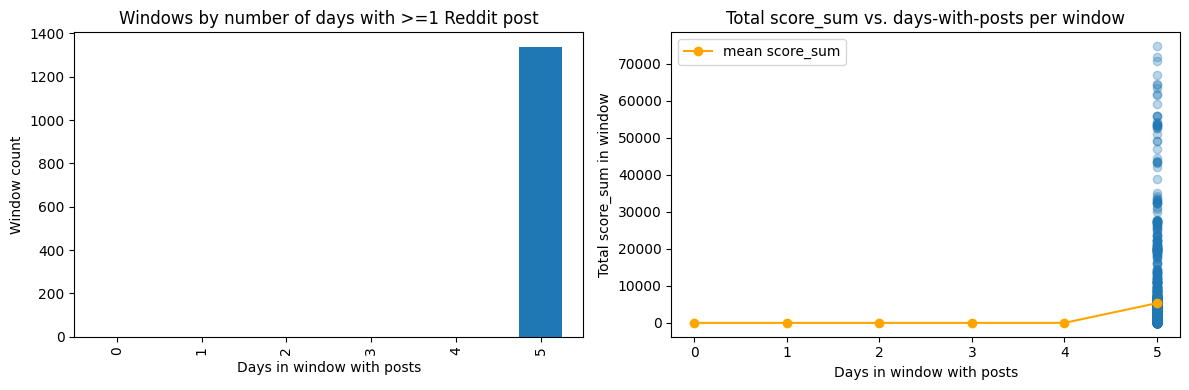

In [34]:
# Coverage of Reddit posts within built sequences + distributions
if len(globals().get('sequences', [])) == 0:
    print('No sequences built yet. Run the sequence-building cell first.')
else:
    rd = reddit.copy()
    rd['date'] = pd.to_datetime(rd['created_utc']).dt.tz_convert('US/Eastern').dt.date
    rd['ticker'] = rd['ticker'].astype(str).str.upper()
    # Use distinct names to avoid collisions with columns already in `merged`
    post_counts = (
        rd.groupby(['ticker','date'])
          .agg(posts=('id','count'), score_sum_day=('score','sum'))
          .reset_index()
    )

    mp = merged.merge(post_counts, on=['ticker','date'], how='left')
    mp['posts'] = mp['posts'].fillna(0).astype(int)
    mp['score_sum_day'] = mp.get('score_sum_day', 0).fillna(0)

    rows = []
    seq_len_local = int(lengths[0]) if len(lengths) else None
    for k, m in enumerate(meta):
        tic = m.get('ticker')
        start_idx = int(m.get('start_index', 0))
        g = (mp[mp['ticker'] == tic]
             .sort_values('date')
             .reset_index(drop=True))
        T = int(sequences[k].shape[0])
        w = g.iloc[start_idx:start_idx+T]
        days_with_post = int((w['posts'] > 0).sum())
        total_posts = int(w['posts'].sum())
        total_score = float(w['score_sum_day'].sum())
        rows.append({
            'k': k,
            'ticker': tic,
            'T': T,
            'days_with_post': days_with_post,
            'has_any_day': days_with_post > 0,
            'has_all_days': days_with_post == T,
            'total_posts': total_posts,
            'total_score_sum': total_score,
        })

    cov = pd.DataFrame(rows)

    total_windows = len(cov)
    any_day = int(cov['has_any_day'].sum())
    all_days = int(cov['has_all_days'].sum())
    print(f'Total windows: {total_windows}')
    print(f'Windows with at least one Reddit post on ANY day: {any_day} ({any_day/max(total_windows,1):.1%})')
    print(f'Windows with a Reddit post EVERY day: {all_days} ({all_days/max(total_windows,1):.1%})')

    max_days = int(cov['T'].max()) if not cov.empty else (seq_len_local or 5)
    dist = cov['days_with_post'].value_counts().reindex(range(0, max_days+1), fill_value=0)
    mean_score_by_days = cov.groupby('days_with_post')['total_score_sum'].mean().reindex(range(0, max_days+1), fill_value=0)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    dist.plot(kind='bar', ax=ax[0])
    ax[0].set_title('Windows by number of days with >=1 Reddit post')
    ax[0].set_xlabel('Days in window with posts')
    ax[0].set_ylabel('Window count')

    ax[1].scatter(cov['days_with_post'], cov['total_score_sum'], alpha=0.3)
    ax[1].plot(mean_score_by_days.index, mean_score_by_days.values, color='orange', marker='o', label='mean score_sum')
    ax[1].set_title('Total score_sum vs. days-with-posts per window')
    ax[1].set_xlabel('Days in window with posts')
    ax[1].set_ylabel('Total score_sum in window')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [35]:
from dataset import WeeklySentimentDataset, collate_weekly
from model import LSTMClassifier

# Build dataset
if len(sequences) == 0:
    print('No sequences built. Check your input coverage and date ranges.')
else:
    ds = WeeklySentimentDataset(
        sequences=sequences,
        lengths=lengths,
        direction=torch.tensor(labels_dir),
        magnitude=torch.tensor(labels_mag),
        metadata=meta,
    )
    batch = collate_weekly([ds[i] for i in range(min(8, len(ds)))], pad_to=5)

    input_dim = sequences[0].shape[1]
    model = LSTMClassifier(input_dim=input_dim).to(device)
    out = model(batch['x'].to(device), batch['lengths'].to(device))
    {k: tuple(v.shape) for k, v in out.items() if isinstance(v, torch.Tensor)}

Generating train/test/split of tesnors

In [36]:
# Compute confidence labels (calendar-based over trading days)
print('Computing confidence labels based on trading-day coverage')

confidence_labels = []
if len(globals().get('sequences', [])) == 0:
    print('No sequences available. Build sequences first.')
else:
    # Build trading calendar per ticker from Yahoo Finance long df `yf`
    cal_map = {tic: sorted(g['date'].dropna().unique().tolist()) for tic, g in yf.groupby('ticker')}

    # Build per-day post counts per ticker from Reddit
    rd = reddit.copy()
    rd['date'] = pd.to_datetime(rd['created_utc']).dt.tz_convert('US/Eastern').dt.date
    rd['ticker'] = rd['ticker'].astype(str).str.upper()
    key_col = 'post_id' if 'post_id' in rd.columns else ('id' if 'id' in rd.columns else None)
    if key_col:
        post_counts = rd.groupby(['ticker','date'])[key_col].size().reset_index(name='posts')
    else:
        post_counts = rd.groupby(['ticker','date']).size().reset_index(name='posts')
    pc_map = {(row['ticker'], row['date']): int(row['posts']) for _, row in post_counts.iterrows()}

    # For each built window, anchor to its start date then look ahead T trading days
    for k, m in enumerate(meta):
        tic = m.get('ticker')
        T = int(sequences[k].shape[0])
        try:
            g = (merged[merged['ticker'] == tic]
                 .sort_values('date')
                 .reset_index(drop=True))
            start_idx = int(m.get('start_index', 0))
            start_date = g.loc[start_idx, 'date']
            cal = cal_map.get(tic, [])
            if not cal:
                confidence_labels.append(1.0)
                continue
            # Find the start_date position within the trading calendar
            idx = int(np.searchsorted(cal, start_date))
            # If the exact date exists at idx-1, step back to align
            if idx < len(cal) and cal[idx] != start_date and idx > 0 and cal[idx-1] == start_date:
                idx = idx - 1
            window_dates = cal[idx: idx + T]
            if len(window_dates) == 0:
                confidence_labels.append(1.0)
                continue
            days_with_post = sum(1 for d in window_dates if pc_map.get((tic, d), 0) > 0)
            conf = float(days_with_post) / float(len(window_dates))
            confidence_labels.append(conf)
        except Exception:
            confidence_labels.append(1.0)

    if len(confidence_labels):
        print(f"Built {len(confidence_labels)} confidence labels. min={float(np.min(confidence_labels)):.2f}, max={float(np.max(confidence_labels)):.2f}")
    else:
        print('No confidence labels built.')

Computing confidence labels based on trading-day coverage
Built 1338 confidence labels. min=0.20, max=1.00
Built 1338 confidence labels. min=0.20, max=1.00


In [37]:
# Train/Val/Test split (70/20/10) and save tensors (variant with title+selftext embeddings)
import os, json
from sklearn.model_selection import train_test_split

print('Generating 70/20/10 train/val/test split of tensors (title+selftext variant)')

if len(sequences) == 0:
    print('No sequences available. Run the preprocessing cells above first.')
else:
    rng_seed = 42
    desired_train, desired_val, desired_test = 0.70, 0.20, 0.10
    assert abs(desired_train + desired_val + desired_test - 1.0) < 1e-6, "Splits must sum to 1.0"

    indices = np.arange(len(sequences))

    train_val_idx, test_idx = train_test_split(indices, test_size=desired_test, random_state=rng_seed, shuffle=True)
    rel_val = desired_val / (1.0 - desired_test)
    train_idx, val_idx = train_test_split(train_val_idx, test_size=rel_val, random_state=rng_seed, shuffle=True)

    has_conf = len(globals().get('confidence_labels', [])) == len(sequences)

    def build_split(idxs):
        x = torch.stack([torch.nan_to_num(sequences[i], nan=0.0, posinf=0.0, neginf=0.0) for i in idxs], dim=0)
        lengths_t = torch.tensor([int(lengths[i]) for i in idxs], dtype=torch.long)
        direction_t = torch.tensor([labels_dir[i] for i in idxs], dtype=torch.float32)
        magnitude_t = torch.tensor([labels_mag[i] for i in idxs], dtype=torch.float32)
        payload = {
            'x': x,
            'lengths': lengths_t,
            'direction': direction_t,
            'magnitude': magnitude_t,
            'meta': [meta[i] for i in idxs],
        }
        if has_conf:
            payload['confidence'] = torch.tensor([confidence_labels[i] for i in idxs], dtype=torch.float32)
        return payload

    train_data = build_split(train_idx)
    val_data = build_split(val_idx)
    test_data = build_split(test_idx)

    out_dir = os.path.join('tensors', 'tensors-2')
    os.makedirs(out_dir, exist_ok=True)
    torch.save(train_data, os.path.join(out_dir, 'train.pt'))
    torch.save(val_data, os.path.join(out_dir, 'val.pt'))
    torch.save(test_data, os.path.join(out_dir, 'test.pt'))

    with open(os.path.join(out_dir, 'train_meta.json'), 'w') as f: json.dump(train_data['meta'], f)
    with open(os.path.join(out_dir, 'val_meta.json'), 'w') as f: json.dump(val_data['meta'], f)
    with open(os.path.join(out_dir, 'test_meta.json'), 'w') as f: json.dump(test_data['meta'], f)

    def summarize(name, data):
        B, T, D = tuple(data['x'].shape)
        parts = [f"{name}: x={B}x{T}x{D}"]
        parts.append(f"lengths[min,max]=({int(data['lengths'].min())},{int(data['lengths'].max())})")
        if 'confidence' in data:
            parts.append(f"confidence[min,max]=({float(data['confidence'].min()):.2f},{float(data['confidence'].max()):.2f})")
        print(', '.join(parts))

    total = len(indices)
    pct = lambda n: 100.0 * n / max(total, 1)
    print(f"Total samples: {total}")
    print(f"Train: {len(train_idx)} ({pct(len(train_idx)):.1f}%), Val: {len(val_idx)} ({pct(len(val_idx)):.1f}%), Test: {len(test_idx)} ({pct(len(test_idx)):.1f}%)")
    summarize('train', train_data)
    summarize('val', val_data)

Generating 70/20/10 train/val/test split of tensors (title+selftext variant)
Total samples: 1338
Train: 936 (70.0%), Val: 268 (20.0%), Test: 134 (10.0%)
train: x=936x5x780, lengths[min,max]=(5,5), confidence[min,max]=(0.20,1.00)
val: x=268x5x780, lengths[min,max]=(5,5), confidence[min,max]=(0.20,1.00)


In [38]:
# Save augmented sentiment variant (title+selftext + separate selftext sentiments)
import os, json, torch
from sklearn.model_selection import train_test_split
print('Saving augmented sentiment variant to tensors/tensors-3 (70/20/10 split)')
if len(sequences)==0:
    print('No sequences; abort saving variant.')
else:
    rng_seed=123
    desired_train, desired_val, desired_test = 0.70,0.20,0.10
    indices = np.arange(len(sequences))
    train_val_idx, test_idx = train_test_split(indices, test_size=desired_test, random_state=rng_seed, shuffle=True)
    rel_val = desired_val / (1.0 - desired_test)
    train_idx, val_idx = train_test_split(train_val_idx, test_size=rel_val, random_state=rng_seed, shuffle=True)
    has_conf = len(globals().get('confidence_labels', [])) == len(sequences)
    def build_split(idxs):
        x = torch.stack([torch.nan_to_num(sequences[i], nan=0.0) for i in idxs], dim=0)
        lengths_t = torch.tensor([int(lengths[i]) for i in idxs], dtype=torch.long)
        direction_t = torch.tensor([labels_dir[i] for i in idxs], dtype=torch.float32)
        magnitude_t = torch.tensor([labels_mag[i] for i in idxs], dtype=torch.float32)
        payload = {'x':x,'lengths':lengths_t,'direction':direction_t,'magnitude':magnitude_t,'meta':[meta[i] for i in idxs]}
        if has_conf:
            payload['confidence']=torch.tensor([confidence_labels[i] for i in idxs], dtype=torch.float32)
        return payload
    train_data = build_split(train_idx)
    val_data = build_split(val_idx)
    test_data = build_split(test_idx)
    out_dir = os.path.join('tensors','tensors-3')
    os.makedirs(out_dir, exist_ok=True)
    torch.save(train_data, os.path.join(out_dir,'train.pt'))
    torch.save(val_data, os.path.join(out_dir,'val.pt'))
    torch.save(test_data, os.path.join(out_dir,'test.pt'))
    for split_name, data_obj in [('train',train_data),('val',val_data),('test',test_data)]:
        with open(os.path.join(out_dir,f'{split_name}_meta.json'),'w') as f: json.dump(data_obj['meta'], f)
    def summarize(name,data):
        B,T,D = data['x'].shape
        msg = f"{name}: x={B}x{T}x{D}, lengths[min,max]=({int(data['lengths'].min())},{int(data['lengths'].max())})"
        if 'confidence' in data:
            msg += f", confidence[min,max]=({float(data['confidence'].min()):.2f},{float(data['confidence'].max()):.2f})"
        print(msg)
    total=len(indices); pct=lambda n:100.0*n/max(total,1)
    print(f'Total samples: {total} | Train {len(train_idx)} ({pct(len(train_idx)):.1f}%) | Val {len(val_idx)} ({pct(len(val_idx)):.1f}%) | Test {len(test_idx)} ({pct(len(test_idx)):.1f}%)')
    summarize('train',train_data); summarize('val',val_data); summarize('test',test_data)

Saving augmented sentiment variant to tensors/tensors-3 (70/20/10 split)
Total samples: 1338 | Train 936 (70.0%) | Val 268 (20.0%) | Test 134 (10.0%)
train: x=936x5x780, lengths[min,max]=(5,5), confidence[min,max]=(0.20,1.00)
val: x=268x5x780, lengths[min,max]=(5,5), confidence[min,max]=(0.20,1.00)
test: x=134x5x780, lengths[min,max]=(5,5), confidence[min,max]=(0.20,1.00)


In [39]:
# Inspect new variant saved under tensors/tensors-2
import os, torch
variant_dir = os.path.join('tensors','tensors-2')
print('Inspecting tensors-2 variant:')
for split in ['train','val','test']:
    p = os.path.join(variant_dir, f'{split}.pt')
    if not os.path.exists(p):
        print(f'Missing {p}')
        continue
    payload = torch.load(p, map_location='cpu')
    keys = sorted(payload.keys())
    print(f'[{split}] keys={keys}')
    x = payload['x']; lens = payload['lengths']
    print('  x', tuple(x.shape), 'lengths', tuple(lens.shape))
    for k in ['direction','magnitude','confidence']:
        if k in payload:
            t = payload[k]
            rng = f"{float(t.min()):.3f}..{float(t.max()):.3f}" if t.ndim==1 else ''
            print(f'  {k}: {tuple(t.shape)} {rng}')
print('Variant ready if x is [B,T,D].')

Inspecting tensors-2 variant:
[train] keys=['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x (936, 5, 780) lengths (936,)
  direction: (936,) 0.000..1.000
  magnitude: (936,) 0.000..0.171
  confidence: (936,) 0.200..1.000
[val] keys=['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x (268, 5, 780) lengths (268,)
  direction: (268,) 0.000..1.000
  magnitude: (268,) 0.000..0.159
  confidence: (268,) 0.200..1.000
[test] keys=['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x (134, 5, 780) lengths (134,)
  direction: (134,) 0.000..1.000
  magnitude: (134,) 0.000..0.197
  confidence: (134,) 0.200..1.000
Variant ready if x is [B,T,D].


In [40]:
# Inspect saved tensor files: list keys and shapes to confirm model readiness
import os, torch, json

def tensor_shape(t):
    return tuple(t.shape) if hasattr(t, 'shape') else None

for split in ['train', 'val', 'test']:
    p = os.path.join('tensors', f'{split}.pt')
    if not os.path.exists(p):
        print(f'{split}.pt not found at {p}')
        continue
    payload = torch.load(p, map_location='cpu')
    keys = sorted(list(payload.keys()))
    print(f'[{split}] keys: {keys}')
    x = payload.get('x'); lens = payload.get('lengths')
    y_dir = payload.get('direction'); y_mag = payload.get('magnitude')
    conf = payload.get('confidence', None)
    print(f'  x: {tensor_shape(x)}, lengths: {tensor_shape(lens)}, direction: {tensor_shape(y_dir)}, magnitude: {tensor_shape(y_mag)}')
    if conf is not None:
        print(f'  confidence: {tensor_shape(conf)} (range {float(conf.min()):.2f}..{float(conf.max()):.2f})')
    meta = payload.get('meta', [])
    print(f'  meta entries: {len(meta)}')

# Ready for model if x is [B,T,D] and lengths is [B]
print('If x is [B,T,D] and lengths is [B], these are ready to pass to LSTMClassifier.')

[train] keys: ['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x: (934, 5, 778), lengths: (934,), direction: (934,), magnitude: (934,)
  confidence: (934,) (range 0.00..1.00)
  meta entries: 934
[val] keys: ['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x: (268, 5, 778), lengths: (268,), direction: (268,), magnitude: (268,)
  confidence: (268,) (range 0.20..1.00)
  meta entries: 268
[test] keys: ['confidence', 'direction', 'lengths', 'magnitude', 'meta', 'x']
  x: (134, 5, 778), lengths: (134,), direction: (134,), magnitude: (134,)
  confidence: (134,) (range 0.20..1.00)
  meta entries: 134
If x is [B,T,D] and lengths is [B], these are ready to pass to LSTMClassifier.
